# Transfer of dimensionless policies on the Half Cheetah

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import gymnasium as gym
from stable_baselines3 import SAC
from huggingface_sb3 import load_from_hub
from tqdm.notebook import tqdm

from pipoli.core import Dimension, Context, DimensionalPolicy, ScaledPolicy
from pipoli.sources.sb3 import SB3Policy

from make_cheetah import make_cheetah_xml

In [2]:
# thanks to Tony Saad for pointing to this solution
# [http://www.tonysaad.net/code/vector-graphics-plots-using-matplotlib-in-jupyter/]
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

In [3]:
OUTDIR = Path("output")
XML_FILES = OUTDIR / "xml_files"
DATADIR = OUTDIR / "data"

OUTDIR.mkdir(exist_ok=True)
XML_FILES.mkdir(exist_ok=True)
DATADIR.mkdir(exist_ok=True)

## Original Half Cheetah

Follows the definition of the original Half Cheetah context.

In [4]:
base_dimensions = [
    M := Dimension([1, 0, 0]),
    L := Dimension([0, 1, 0]),
    T := Dimension([0, 0, 1]),
]
Unit = Dimension([0, 0, 0])

In [5]:
original_context = Context(
    base_dimensions,
    *zip(
        ("dt", T, 0.01),
        ("m", M, 14),
        ("g", L/T**2, 9.81),
        ("taumax", M*L**2/T**2, 1),
        ("L", L, 0.5),
        ("Lh", L, 0.15),
        ("l0", L, 0.145),
        ("l1", L, 0.15),
        ("l2", L, 0.094),
        ("l3", L, 0.133),
        ("l4", L, 0.106),
        ("l5", L, 0.07),
        ("k0", M*L**2/T**2, 240),
        ("k1", M*L**2/T**2, 180),
        ("k2", M*L**2/T**2, 120),
        ("k3", M*L**2/T**2, 180),
        ("k4", M*L**2/T**2, 120),
        ("k5", M*L**2/T**2, 60),
        ("b0", M*L**2/T, 6),
        ("b1", M*L**2/T, 4.5),
        ("b2", M*L**2/T, 3),
        ("b3", M*L**2/T, 4.5),
        ("b4", M*L**2/T, 3),
        ("b5", M*L**2/T, 1.5),
    )
)
original_cheetah_file = make_cheetah_xml(original_context, "original", outdir=XML_FILES)

Original policy instantiation.

In [6]:
halfcheetah_v5_sac_expert =  load_from_hub(
    repo_id="farama-minari/HalfCheetah-v5-SAC-expert",
    filename="halfcheetah-v5-sac-expert.zip",
)
model = SAC.load(halfcheetah_v5_sac_expert)

sb3_policy = SB3Policy(
    model,
    model_obs_space=gym.spaces.Box(-np.inf, np.inf, (17,), np.float64),
    model_act_space=gym.spaces.Box(-1.0, 1.0, (6,), np.float32),
    predict_kwargs=dict(deterministic=True)
)

original_policy = DimensionalPolicy(
    sb3_policy,
    original_context,
    obs_dims=[L] + [Unit] * 7 + [L/T] * 2 + [1/T] * 7,
    act_dims=[M*L**2/T**2] * 6
)

## Data generation

### Utilities

Hide this section for better legibility.

In [7]:
def make_context_sweep(context, base, range1, range2, range3, outdir="./output"):
    contexts = {}

    for b1 in range1:
        for b2 in range2:
            for b3 in range3:
                new_context = context.scale_to(base, [b1, b2, b3])
                xml_file = make_cheetah_xml(new_context, f"{b1:.2f}-{b2:.2f}-{b3:.2f}", outdir=outdir)

                contexts[xml_file] = new_context
    
    return contexts

In [8]:
def record_episode(env, policy, nb_steps, close=True):
    observations = np.zeros((nb_steps,) + env.observation_space.shape)
    actions = np.zeros((nb_steps,) + env.action_space.shape)
    infos = [None] * nb_steps
    rewards = np.zeros(nb_steps)

    obs, info = env.reset()
    act = policy.action(obs)

    for i in range(nb_steps):
        observations[i] = obs
        actions[i] = act

        obs, rew, _, trunc, info = env.step(act)
        act = policy.action(obs)

        rewards[i] = rew
        infos[i] = info

        if trunc:
            break
    
    if close:
        env.close()

    return observations, actions, rewards, infos, i, trunc

### Make contexts

In [26]:
base = ["m", "L", "g"]

SPACE = "log"
GRID_SIZE = 5

if SPACE == "log":
    ms = np.logspace(-1, 1, num=GRID_SIZE) * original_context.value("m")
    Ls = np.logspace(-1, 1, num=GRID_SIZE) * original_context.value("L")
elif SPACE == "lin":
    ms = np.linspace(0.1, 10, num=GRID_SIZE) * original_context.value("m")
    Ls = np.linspace(0.1, 10, num=GRID_SIZE) * original_context.value("L")
else:
    assert False, "wrong SPACE value"

gs = [original_context.value("g")]

all_contexts = make_context_sweep(original_context, base, ms, Ls, gs, outdir=XML_FILES)

### Generate data

In [10]:
NB_STEPS = 1000

df = pd.DataFrame(columns=["m", "L", "g", "context", "observations", "actions", "rewards", "infos", "last_step"])
df.attrs["max_steps"] = NB_STEPS
df.attrs["base"] = base

# original
m = original_context.value("m")
L_ = original_context.value("L")
g = original_context.value("g")
env = gym.make("HalfCheetah-v5", xml_file=original_cheetah_file, render_mode=None)
observations, actions, rewards, infos, last_step, trunc = record_episode(env, original_policy, NB_STEPS)
df.loc["original"] = [m, L_, g, original_context, observations, actions, rewards, infos, last_step]

# all others
for xml_file, context in tqdm(all_contexts.items()):
    m = context.value("m")
    L_ = context.value("L")
    g = context.value("g")

    env = gym.make("HalfCheetah-v5", xml_file=xml_file, render_mode=None)
    policy = original_policy.to_scaled(context=context, base=base)
    observations, actions, rewards, infos, last_step, trunc = record_episode(env, policy, NB_STEPS)

    index = xml_file.split("/")[-1].removesuffix(".xml")
    df.loc[index] = [m, L_, g, context, observations, actions, rewards, infos, last_step]

  0%|          | 0/25 [00:00<?, ?it/s]

In [27]:

df.to_pickle(DATADIR / f"data-{SPACE}-{GRID_SIZE}-{NB_STEPS}.pkl.gz")

## Data analysis

In [12]:
df = pd.read_pickle(DATADIR / f"data-{SPACE}-{GRID_SIZE}-{NB_STEPS}.pkl.gz")
base = df.attrs["base"]

### Score vs distance analysis

In [13]:
def adim_reward_forward(context, infos):
    forward_reward_adim, _ = context.make_transforms([L / T], base)

    fwd_rews = np.array([forward_reward_adim(info["reward_forward"]) for info in infos])

    return fwd_rews

def adim_reward_ctrl(context, infos):
    control_cost_adim, _ = context.make_transforms([M*L**2/T**2], base)
    ctl_costs = np.array([control_cost_adim(info["reward_ctrl"]) for info in infos])

    return ctl_costs

Building the score dataframe.

In [14]:
score_df = df.sort_values(["m", "L"])[["m", "L", "context", "infos"]]

In [15]:
score_df["adimensional_distance_to_original"] = score_df["context"].map(lambda c: c.adimensional_distance(original_context, base))
score_df["cosine_similarity_to_original"] = score_df["context"].map(lambda c: c.cosine_similarity(original_context))
score_df["euclidian_distance_to_original"] = score_df["context"].map(lambda c: c.euclidian_distance(original_context))
score_df["rewards_forward"] = score_df.apply(lambda row: adim_reward_forward(row["context"], row["infos"]), axis=1)
score_df["rewards_ctrl"] = score_df.apply(lambda row: adim_reward_ctrl(row["context"], row["infos"]), axis=1)
score_df["rewards_total_per_step"] = score_df.apply(lambda row: row["rewards_forward"] + row["rewards_ctrl"], axis=1)
score_df["reward_forward_total"] = score_df["rewards_forward"].map(np.sum)
score_df["reward_ctrl_total"] = score_df["rewards_ctrl"].map(np.sum)
score_df["reward_total"] = score_df["rewards_total_per_step"].map(np.sum)
score_df["mean_reward_per_step"] = score_df["rewards_total_per_step"].map(np.mean)
score_df["std_reward_per_step"] = score_df["rewards_total_per_step"].map(np.std)
score_df["norm_std_reward_per_step"] = score_df["rewards_total_per_step"].map(lambda r: np.std(r) / np.abs(np.mean(r)))

In [16]:
final_score_df = score_df.drop(columns=["context", "infos", "rewards_forward", "rewards_ctrl", "rewards_total_per_step"])
final_score_df

,m,L,adimensional_distance_to_original,cosine_similarity_to_original,euclidian_distance_to_original,reward_forward_total,reward_ctrl_total,reward_total,mean_reward_per_step,std_reward_per_step,norm_std_reward_per_step
cheetah-1.40-0.05-9.81,1.400000,0.050000,0.000000e+00,0.396211,389.840544,0.222560,-0.087089,0.135472,0.000135,0.037689,278.208368
cheetah-1.40-0.16-9.81,1.400000,0.158114,5.737111e-16,0.799913,381.336588,5.585683,-0.274406,5.311277,0.005311,0.041439,7.802171
cheetah-1.40-0.50-9.81,1.400000,0.500000,6.938894e-17,0.975981,354.437494,35.299925,-0.448314,34.851611,0.034852,0.137608,3.948392
cheetah-1.40-1.58-9.81,1.400000,1.581139,7.850462e-17,0.997983,269.360948,1.141225,-0.602395,0.538830,0.000539,0.042888,79.594065
cheetah-1.40-5.00-9.81,1.400000,5.000000,1.144392e-16,0.997945,25.301449,19.276025,-3.855336,15.420689,0.015421,0.106949,6.935402
cheetah-4.43-0.05-9.81,4.427189,0.050000,1.779831e-15,0.779898,381.250679,1.648726,-0.275411,1.373315,0.001373,0.047645,34.693697
cheetah-4.43-0.16-9.81,4.427189,0.158114,8.470017e-16,0.973443,354.354048,-0.445020,-0.858859,-1.303879,-0.001304,0.035443,27.182515
cheetah-4.43-0.50-9.81,4.427189,0.500000,8.418701e-16,0.998553,269.282797,900.347090,-1.236638,899.110452,0.899110,1.462146,1.626215
cheetah-4.43-1.58-9.81,4.427189,1.581139,1.716588e-16,0.999511,12.325546,42.456272,-5.707961,36.748311,0.036748,0.129913,3.535204
cheetah-4.43-5.00-9.81,4.427189,5.000000,1.280147e-15,0.997887,855.406894,24.369774,-14.936973,9.432801,0.009433,0.124969,13.248319


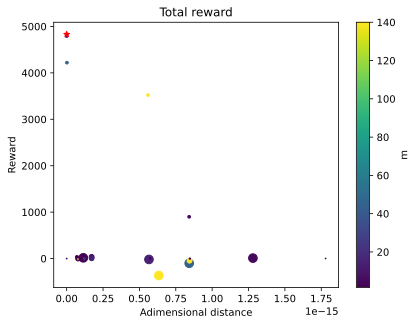

In [17]:
viz_df = final_score_df.sort_values(["adimensional_distance_to_original"])

viz_df.plot.scatter(
    x="adimensional_distance_to_original",
    y="reward_total",
    s=viz_df["L"]*15,
    c="m",
    xlabel="Adimensional distance",
    ylabel="Reward",
    title="Total reward",
    legend=False,
    # logx=True,
)
plt.scatter(0, final_score_df.loc["original"]["reward_total"], c="r", marker="*")

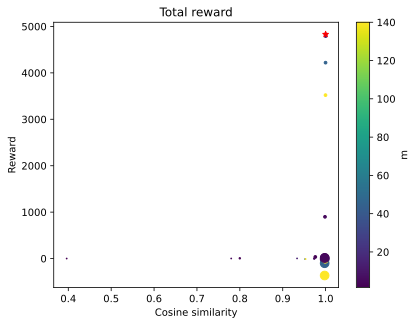

In [18]:
viz_df = final_score_df.sort_values(["adimensional_distance_to_original"])

viz_df.plot.scatter(
    x="cosine_similarity_to_original",
    y="reward_total",
    s=viz_df["L"]*15,
    c="m",
    xlabel="Cosine similarity",
    ylabel="Reward",
    title="Total reward",
    legend=False,
    # logx=True,
)
plt.scatter(1, final_score_df.loc["original"]["reward_total"], c="r", marker="*")

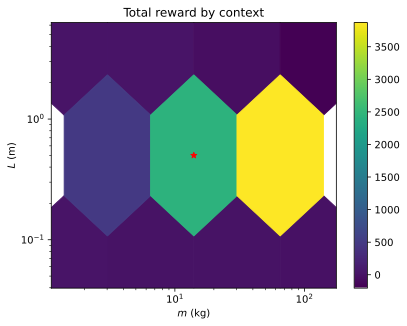

In [19]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="reward_total",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Total reward by context",
    xscale="log",
    yscale="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

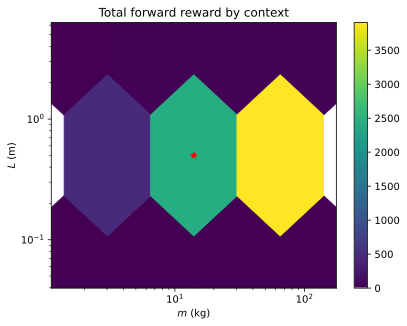

In [20]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="reward_forward_total",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Total forward reward by context",
    xscale="log",
    yscale="log",
    # bins="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

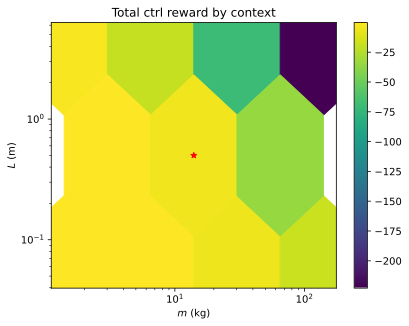

In [21]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="reward_ctrl_total",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Total ctrl reward by context",
    xscale="log",
    yscale="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

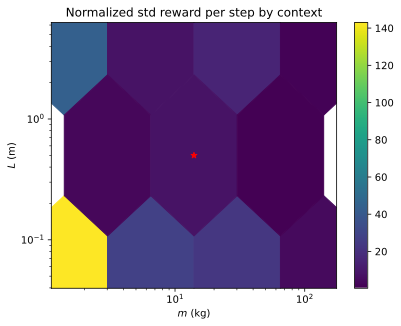

In [22]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="norm_std_reward_per_step",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Normalized std reward per step by context",
    xscale="log",
    yscale="log",
    # bins="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

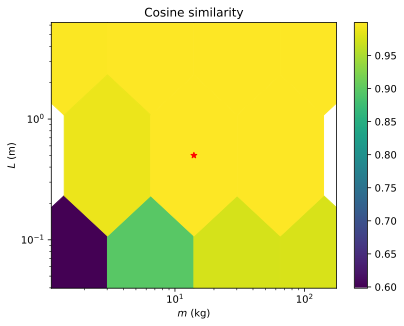

In [23]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="cosine_similarity_to_original",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Cosine similarity",
    xscale="log",
    yscale="log",
    # bins="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

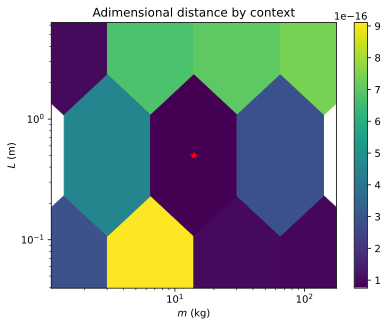

In [24]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="adimensional_distance_to_original",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Adimensional distance by context",
    xscale="log",
    yscale="log",
    # bins="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

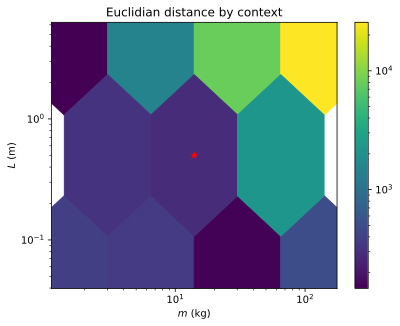

In [25]:
final_score_df.plot.hexbin(
    x="m",
    y="L",
    C="euclidian_distance_to_original",
    gridsize=int(np.sqrt(final_score_df.shape[0])/1.4),
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    title="Euclidian distance by context",
    xscale="log",
    yscale="log",
    bins="log",
    cmap="viridis",
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")